In [69]:
import numpy as np
import pandas as pd
import os
from nltk.stem.snowball import SnowballStemmer

import re
import gensim
from gensim.corpora import *
from gensim.models import  *
from gensim import similarities

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import *


from sklearn.metrics import *
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import transformers
import nltk

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import HTML




%matplotlib inline
warnings.filterwarnings("ignore")

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist

nltk.download('stopwords')
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Helen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Helen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
#чтение данных

DATA_DIR ="../data/bbc/"

def get_dataset(DATA_DIR):
    data = []
    for file in [os.path.join(path, name) for path, subdirectory, files in os.walk(DATA_DIR) for name in files]:
        label = file.split("/")[3].split("\\")[0]
        content = " ".join(open(file, encoding='utf-8', errors='ignore').read().splitlines())
        data.append((content, label))
    return data


In [11]:
data = get_dataset(DATA_DIR)
data = pd.DataFrame(data, columns=['text', 'label'])
data

,text,label
0,Ad sales boost Time Warner profit Quarterly p...,business
1,Dollar gains on Greenspan speech The dollar h...,business
2,Yukos unit buyer faces loan claim The owners ...,business
3,High fuel prices hit BA's profits British Air...,business
4,Pernod takeover talk lifts Domecq Shares in U...,business
...,...,...
2160,Can Yahoo dominate next decade? Yahoo has rea...,tech
2161,Looks and music to drive mobiles Mobile phone...,tech
2162,Hotspot users gain free net calls People usin...,tech
2163,Domain system opens door to scams A system to...,tech


In [12]:
stopwords=nltk.corpus.stopwords.words("english")
additional_words=["us", "always", "said", "then", "also", "usually", "would", "new", "last", "could", "year", "mr", "mrs","told", "say", "however", "may", "one", "two"]
stopwords+=additional_words

In [13]:
stemmer=SnowballStemmer(language='english')

In [14]:
regex = re.compile("[A-Za-z]+")
frequency=FreqDist()
top_words = []

In [125]:
def words_only(text, myregex=regex):
        try:
            return " ".join(myregex.findall(text))
        except:
            return ""


def lemmatize(text, mystemmer=stemmer):
    try:
        tokens=[mystemmer.stem(token) for token in text.split()]
        return " ".join(tokens)
    except:
         return ""

def tokenize(text, mystopwords=stopwords):
    return [word for word in word_tokenize(text.lower()) if word not in mystopwords]


def delete_some(text, myfreq=frequency, mytop=top_words):
    return [token for token in text if (myfreq[token] > 1) and (token not in mytop) and (len(token)>3)]



In [126]:
def preprocess_data(data, label):
    data=data[data['label']==label]

    data.text = data.text.apply(words_only)
    data.text = data.text.apply(lemmatize)
    data.text = data.text.apply(tokenize)


    for i in range(len(data)):
        frequency.update(data.text.iloc[i])

    top_words = []

    for word in frequency.most_common(1000):
        top_words.append(word[0])

    data.text = data.text.apply(delete_some)



    dictionary=Dictionary(data.text)
    corpus=[dictionary.doc2bow(text) for text in data.text]



    return data, dictionary, corpus


def plot_similarity_matrix(corpus, label):
    index = similarities.MatrixSimilarity(corpus)
    sims = index[corpus]
    plt.figure(figsize = (6,6))
    sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
    plt.title("Матрица близости для класса: {}".format(label))
    plt.show()



def LDA_modeling(corpus, dictionary, num_topics):
    lda = ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha='auto', eta='auto', iterations = 20, passes=5, random_state=0, eval_every=None)
    topics=lda.print_topics(num_topics=num_topics, num_words=5)
    print("Topics:")
    print(topics)
    topic_words=[]
    for topic in topics:
        topic_words.append(" ".join(re.findall('[a-z]+', topic[1])))
    for i, topic in enumerate(topics):
        print("Topic {}:".format(topic[0]))
        print("words: {}".format(topic_words[i]))
    return lda, topic_words


def get_topic(data, dict, topic_words, model):
    topic=[0]*len(data)
    topic_w=[""]*len(data)
    for i in range(len(data)):
        text=data.text.iloc[i]
        bow = dict.doc2bow(text)
        topic[i]=max(model.get_document_topics(bow), key=lambda x: x[1])[0] # № максимально вероятная тема
        topic_w[i]=topic_words[topic[i]] #слова для i-ой темы
    data['topic']=topic
    data['topic_words']=topic_w
    return data

def TSNE_vis(data, dict, num_topics):
    vec = CountVectorizer(vocabulary=dict.token2id)
    vectors=vec.fit_transform(data.text.apply(lambda x: " ".join(x)))
    X_reduced = TruncatedSVD(n_components=num_topics, n_iter=7, random_state=0).fit_transform(vectors)
    X_embedded = TSNE(n_components=2, perplexity=5, verbose=0).fit_transform(X_reduced)
    vis_df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic': data['topic_words']})
    sns.FacetGrid(vis_df, hue="topic").map(plt.scatter, "X", "Y").add_legend()




In [127]:
def make_pipline(data, label, num_topics):
    data, dict, corpus = preprocess_data(data, label)
    plot_similarity_matrix(corpus, label)
    lda, topic_words=LDA_modeling(corpus, dict, num_topics)
    data=get_topic(data, dict, topic_words, lda)
    TSNE_vis(data, dict, num_topics)
    vis_data = gensimvis.prepare(lda, corpus, dict)
    pyLDAvis.enable_notebook(local=True)
    pyLDAvis.display(vis_data)
    pyLDAvis.save_html(vis_data, 'lda_result.html')
    display(HTML('lda_result.html'))

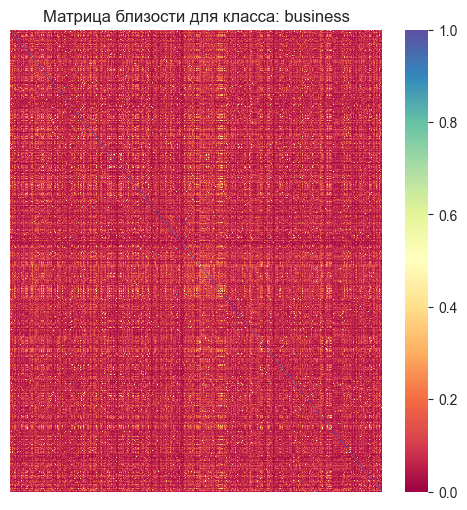

Topics:
[(0, '0.009*"bank" + 0.007*"economi" + 0.007*"econom" + 0.006*"growth" + 0.006*"rate"'), (1, '0.008*"sale" + 0.008*"market" + 0.007*"profit" + 0.006*"share" + 0.006*"growth"'), (2, '0.011*"compani" + 0.009*"firm" + 0.006*"yuko" + 0.006*"govern" + 0.005*"share"')]
Topic 0:
words: bank economi econom growth rate
Topic 1:
words: sale market profit share growth
Topic 2:
words: compani firm yuko govern share


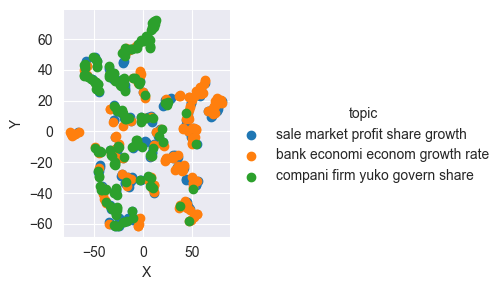

In [128]:
make_pipline(data, "business", 3)

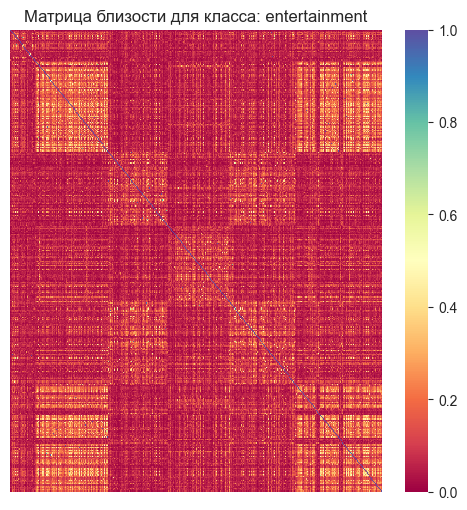

Topics:
[(0, '0.016*"music" + 0.007*"award" + 0.007*"film" + 0.006*"best" + 0.005*"album"'), (1, '0.011*"music" + 0.007*"song" + 0.007*"film" + 0.006*"band" + 0.006*"best"'), (2, '0.015*"film" + 0.014*"show" + 0.006*"star" + 0.004*"includ" + 0.004*"singer"'), (3, '0.025*"film" + 0.018*"best" + 0.014*"award" + 0.013*"star" + 0.008*"actor"'), (4, '0.015*"film" + 0.013*"number" + 0.009*"best" + 0.007*"band" + 0.007*"album"')]
Topic 0:
words: music award film best album
Topic 1:
words: music song film band best
Topic 2:
words: film show star includ singer
Topic 3:
words: film best award star actor
Topic 4:
words: film number best band album


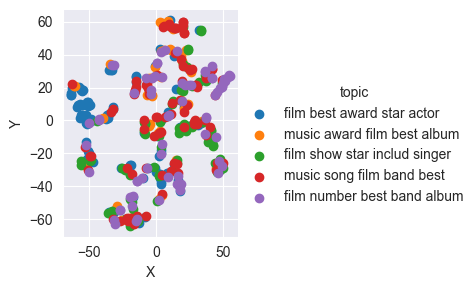

In [129]:
make_pipline(data, "entertainment", 5)

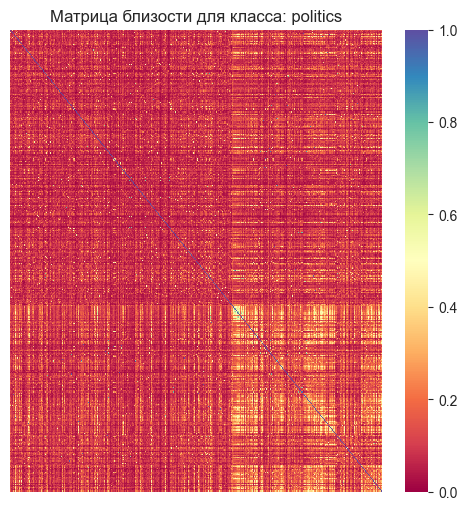

Topics:
[(0, '0.008*"peopl" + 0.007*"govern" + 0.007*"home" + 0.007*"plan" + 0.006*"lord"'), (1, '0.011*"parti" + 0.010*"govern" + 0.008*"lord" + 0.007*"elect" + 0.006*"ukip"'), (2, '0.016*"elect" + 0.015*"labour" + 0.014*"parti" + 0.013*"tori" + 0.008*"peopl"'), (3, '0.011*"blair" + 0.010*"minist" + 0.009*"govern" + 0.009*"brown" + 0.009*"labour"'), (4, '0.009*"hunt" + 0.009*"govern" + 0.008*"brown" + 0.007*"plan" + 0.005*"chancellor"')]
Topic 0:
words: peopl govern home plan lord
Topic 1:
words: parti govern lord elect ukip
Topic 2:
words: elect labour parti tori peopl
Topic 3:
words: blair minist govern brown labour
Topic 4:
words: hunt govern brown plan chancellor


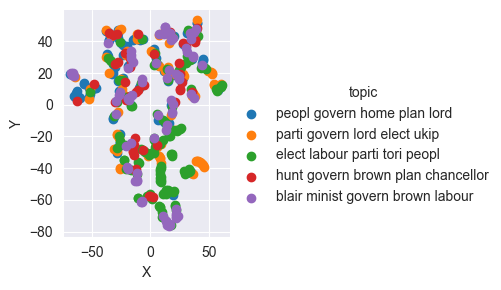

In [130]:
make_pipline(data, "politics", 5)

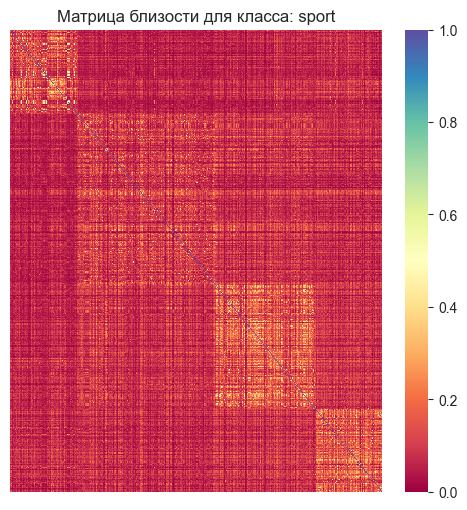

Topics:
[(0, '0.009*"player" + 0.008*"play" + 0.006*"world" + 0.006*"coach" + 0.006*"rugbi"'), (1, '0.010*"final" + 0.009*"world" + 0.009*"play" + 0.007*"open" + 0.007*"first"'), (2, '0.008*"club" + 0.007*"chelsea" + 0.007*"game" + 0.006*"play" + 0.006*"player"'), (3, '0.011*"game" + 0.010*"england" + 0.007*"half" + 0.007*"wale" + 0.007*"first"')]
Topic 0:
words: player play world coach rugbi
Topic 1:
words: final world play open first
Topic 2:
words: club chelsea game play player
Topic 3:
words: game england half wale first


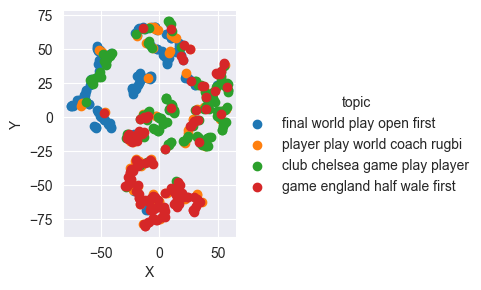

In [131]:
make_pipline(data, "sport", 4)

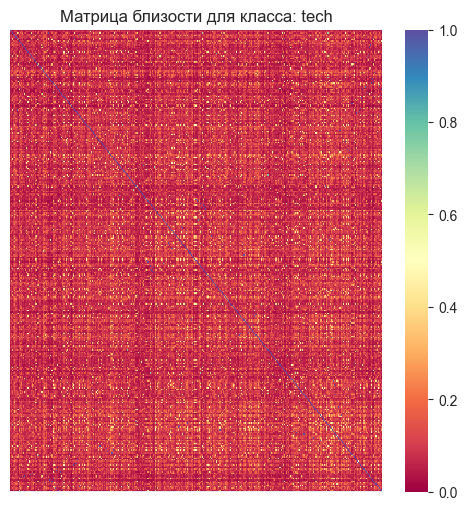

Topics:
[(0, '0.013*"peopl" + 0.009*"phone" + 0.009*"mobil" + 0.007*"million" + 0.007*"site"'), (1, '0.012*"servic" + 0.012*"phone" + 0.011*"peopl" + 0.009*"mobil" + 0.009*"user"'), (2, '0.009*"game" + 0.008*"peopl" + 0.008*"chip" + 0.007*"mobil" + 0.006*"soni"'), (3, '0.013*"music" + 0.008*"peopl" + 0.008*"technolog" + 0.008*"file" + 0.007*"player"'), (4, '0.010*"patent" + 0.008*"high" + 0.007*"technolog" + 0.006*"appl" + 0.006*"definit"'), (5, '0.031*"game" + 0.006*"releas" + 0.006*"play" + 0.006*"peopl" + 0.005*"make"'), (6, '0.013*"peopl" + 0.011*"blog" + 0.010*"broadband" + 0.006*"make" + 0.006*"call"'), (7, '0.010*"peopl" + 0.008*"softwar" + 0.007*"messag" + 0.006*"text" + 0.006*"technolog"'), (8, '0.021*"search" + 0.013*"peopl" + 0.010*"technolog" + 0.009*"user" + 0.009*"digit"'), (9, '0.019*"game" + 0.012*"technolog" + 0.008*"mobil" + 0.006*"peopl" + 0.006*"like"')]
Topic 0:
words: peopl phone mobil million site
Topic 1:
words: servic phone peopl mobil user
Topic 2:
words: game

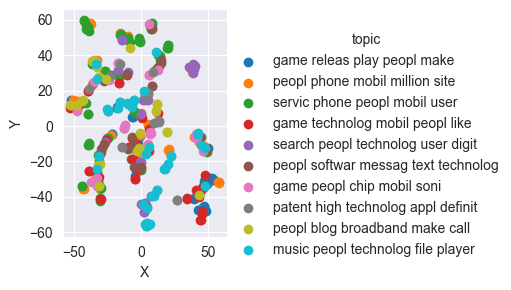

In [132]:
make_pipline(data, "tech", 10)